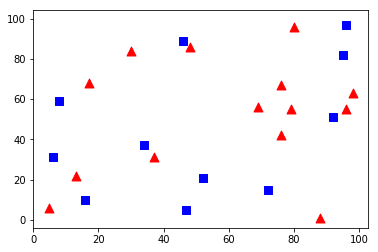

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

# Feature set containing (x,y) values of 25 known/training data
trainData = np.random.randint(0,100,(25,2)).astype(np.float32)

# Labels each one either Red or Blue with numbers 0 and 1
responses = np.random.randint(0,2,(25,1)).astype(np.float32)

# Take Red families and plot them
red = trainData[responses.ravel()==0]
plt.scatter(red[:,0],red[:,1],80,'r','^')

# Take Blue families and plot them
blue = trainData[responses.ravel()==1]
plt.scatter(blue[:,0],blue[:,1],80,'b','s')

plt.show()

In [14]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('digits.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Now we split the image to 5000 cells, each 20x20 size
cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)]

# Make it into a Numpy array. It size will be (50,100,20,20)
x = np.array(cells)

# Now we prepare train_data and test_data.
train = x[:,:50].reshape(-1,400).astype(np.float32) # Size = (2500,400)
test = x[:,50:100].reshape(-1,400).astype(np.float32) # Size = (2500,400)

# Create labels for train and test data
k = np.arange(10)
train_labels = np.repeat(k,250)[:,np.newaxis]
test_labels = train_labels.copy()
'''
knn = cv2.KNearest() # error
knn.train(trainData, responses)  # error
ret, results, neighbours, dist = knn.find_nearest(newcomer, k)  # error


knn = cv2.ml.KNearest_create()
knn.train(trainData,cv2.ml.ROW_SAMPLE,responses)
ret, results, neighbours, dist = knn.findNearest(newcomer, k)
'''
# Initiate kNN, train the data, then test it with test data for k=1
''''
knn = cv2.KNearest()
knn.train(trainData,cv2.ml.ROW_SAMPLE,train_labels)
ret,result,neighbours,dist = knn.find_nearest(test,k=5)
'''
knn = cv2.ml.KNearest_create()
knn.train(trainData,cv2.ml.ROW_SAMPLE,train_labels)
ret, results, neighbours, dist = knn.findNearest(test,k=5)

# Now we check the accuracy of classification
# For that, compare the result with test_labels and check which are wrong
matches = result==test_labels
correct = np.count_nonzero(matches)
accuracy = correct*100.0/result.size
print (accuracy)

error: OpenCV(3.4.1) /io/opencv/modules/ml/src/data.cpp:298: error: (-215) (layout == ROW_SAMPLE && responses.rows == nsamples) || (layout == COL_SAMPLE && responses.cols == nsamples) in function setData


In [15]:
#!/usr/bin/env python

'''
SVM and KNearest digit recognition.
Sample loads a dataset of handwritten digits from '../data/digits.png'.
Then it trains a SVM and KNearest classifiers on it and evaluates
their accuracy.
Following preprocessing is applied to the dataset:
 - Moment-based image deskew (see deskew())
 - Digit images are split into 4 10x10 cells and 16-bin
   histogram of oriented gradients is computed for each
   cell
 - Transform histograms to space with Hellinger metric (see [1] (RootSIFT))
[1] R. Arandjelovic, A. Zisserman
    "Three things everyone should know to improve object retrieval"
    http://www.robots.ox.ac.uk/~vgg/publications/2012/Arandjelovic12/arandjelovic12.pdf
Usage:
   digits.py
'''


# Python 2/3 compatibility
from __future__ import print_function

# built-in modules
from multiprocessing.pool import ThreadPool

import cv2 as cv

import numpy as np
from numpy.linalg import norm

# local modules
from common import clock, mosaic



SZ = 20 # size of each digit is SZ x SZ
CLASS_N = 10
DIGITS_FN = '../data/digits.png'

def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

def load_digits(fn):
    print('loading "%s" ...' % fn)
    digits_img = cv.imread(fn, 0)
    digits = split2d(digits_img, (SZ, SZ))
    labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)
    return digits, labels

def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv.warpAffine(img, M, (SZ, SZ), flags=cv.WARP_INVERSE_MAP | cv.INTER_LINEAR)
    return img

class StatModel(object):
    def load(self, fn):
        self.model.load(fn)  # Known bug: https://github.com/opencv/opencv/issues/4969
    def save(self, fn):
        self.model.save(fn)

class KNearest(StatModel):
    def __init__(self, k = 3):
        self.k = k
        self.model = cv.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        _retval, results, _neigh_resp, _dists = self.model.findNearest(samples, self.k)
        return results.ravel()

class SVM(StatModel):
    def __init__(self, C = 1, gamma = 0.5):
        self.model = cv.ml.SVM_create()
        self.model.setGamma(gamma)
        self.model.setC(C)
        self.model.setKernel(cv.ml.SVM_RBF)
        self.model.setType(cv.ml.SVM_C_SVC)

    def train(self, samples, responses):
        self.model.train(samples, cv.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        return self.model.predict(samples)[1].ravel()


def evaluate_model(model, digits, samples, labels):
    resp = model.predict(samples)
    err = (labels != resp).mean()
    print('error: %.2f %%' % (err*100))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, resp):
        confusion[i, int(j)] += 1
    print('confusion matrix:')
    print(confusion)
    print()

    vis = []
    for img, flag in zip(digits, resp == labels):
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        if not flag:
            img[...,:2] = 0
        vis.append(img)
    return mosaic(25, vis)

def preprocess_simple(digits):
    return np.float32(digits).reshape(-1, SZ*SZ) / 255.0

def preprocess_hog(digits):
    samples = []
    for img in digits:
        gx = cv.Sobel(img, cv.CV_32F, 1, 0)
        gy = cv.Sobel(img, cv.CV_32F, 0, 1)
        mag, ang = cv.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n*ang/(2*np.pi))
        bin_cells = bin[:10,:10], bin[10:,:10], bin[:10,10:], bin[10:,10:]
        mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)

        # transform to Hellinger kernel
        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps

        samples.append(hist)
    return np.float32(samples)


if __name__ == '__main__':
    print(__doc__)

    digits, labels = load_digits(DIGITS_FN)

    print('preprocessing...')
    # shuffle digits
    rand = np.random.RandomState(321)
    shuffle = rand.permutation(len(digits))
    digits, labels = digits[shuffle], labels[shuffle]

    digits2 = list(map(deskew, digits))
    samples = preprocess_hog(digits2)

    train_n = int(0.9*len(samples))
    cv.imshow('test set', mosaic(25, digits[train_n:]))
    digits_train, digits_test = np.split(digits2, [train_n])
    samples_train, samples_test = np.split(samples, [train_n])
    labels_train, labels_test = np.split(labels, [train_n])


    print('training KNearest...')
    model = KNearest(k=4)
    model.train(samples_train, labels_train)
    vis = evaluate_model(model, digits_test, samples_test, labels_test)
    cv.imshow('KNearest test', vis)

    print('training SVM...')
    model = SVM(C=2.67, gamma=5.383)
    model.train(samples_train, labels_train)
    vis = evaluate_model(model, digits_test, samples_test, labels_test)
    cv.imshow('SVM test', vis)
    print('saving SVM as "digits_svm.dat"...')
    model.save('digits_svm.dat')

cv.waitKey(0)

ModuleNotFoundError: No module named 'common'